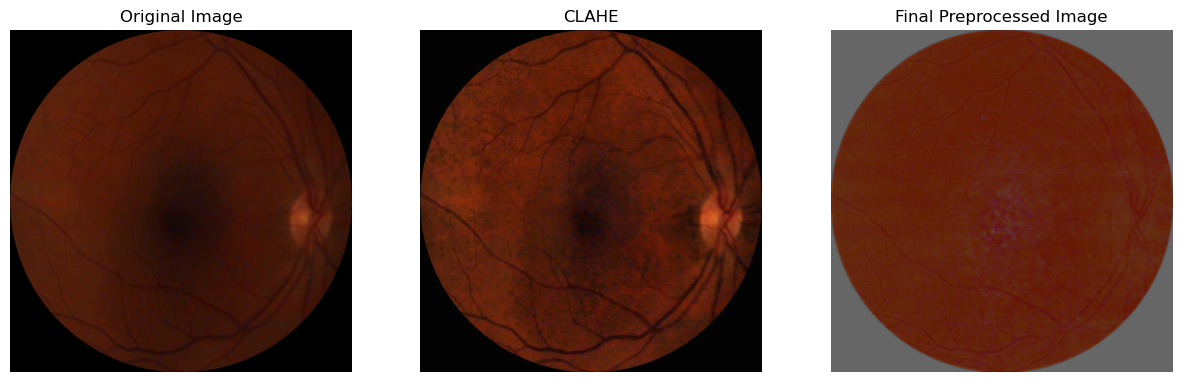

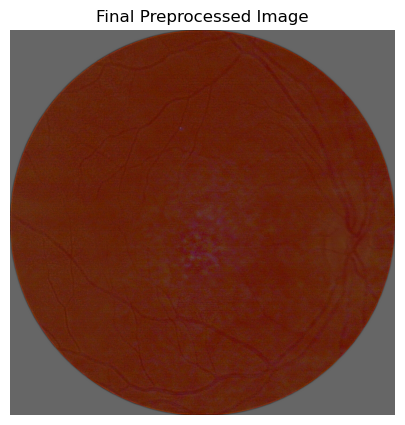

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_images(images, titles):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    if n == 1:
        axs = [axs]
    for i in range(n):
        axs[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) if images[i].ndim == 3 and images[i].shape[2] == 3 else images[i], cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(image.shape) == 2:  # Grayscale image
        return clahe.apply(image)
    elif len(image.shape) == 3 and image.shape[2] == 3:  # Color image
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv_planes = list(cv2.split(hsv_image))  # Convert to list to allow modification
        hsv_planes[2] = clahe.apply(hsv_planes[2])
        return cv2.cvtColor(cv2.merge(hsv_planes), cv2.COLOR_HSV2BGR)
    else:
        raise ValueError("Unsupported image format for CLAHE")

def fundus_roi(image, mask=None):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    threshold = 15
    _, roi = cv2.threshold(v, threshold, 1, cv2.THRESH_BINARY)
    roi = roi.astype(np.uint8)
    white_pixels = np.argwhere(roi == 1)
    if white_pixels.size == 0:
        print("Aucun pixel blanc trouvé dans le masque.")
        return {"roi": roi, "diameter": 0, "image": image}
    x_min, y_min = np.min(white_pixels, axis=0)
    x_max, y_max = np.max(white_pixels, axis=0)
    diameter_x = x_max - x_min
    diameter_y = y_max - y_min
    diameter = int(np.maximum(diameter_x, diameter_y))
    return {"roi": roi, "diameter": diameter, "image": image}

def apply_sarki(image):
    images = []
    titles = []

    data = fundus_roi(image)
    images.append(image)
    titles.append("Original Image")

    clahe_image = apply_clahe(data["image"])
    images.append(clahe_image)
    titles.append("CLAHE")

    hsv_clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_BGR2HSV)
    hsv_float = hsv_clahe_image.astype(np.float32) / 255.0

    mu0 = 0.4  #
    muL = cv2.blur(hsv_float[:, :, 2], (15, 15)) 
    v_processed = hsv_float[:, :, 2] + mu0 - muL
    v_processed = np.clip(v_processed, 0, 1)

    hsv_float[:, :, 2] = v_processed

    # Convert back to uint8 for display
    hsv_uint8 = (hsv_float * 255).astype(np.uint8)
    final_image = cv2.cvtColor(hsv_uint8, cv2.COLOR_HSV2BGR)

    images.append(final_image)
    titles.append("Final Preprocessed Image")
    plot_images(images, titles)

    return {"image": final_image}

# Load the image
image = cv2.imread('../data/image_1.png')
if image is None:
    print("Erreur: Impossible de charger l'image.")
else:
    image = image.astype(np.uint8)
    sarki_image = apply_sarki(image)
    if sarki_image is not None:
        plot_images([sarki_image['image']], ['Final Preprocessed Image'])
